(tsp2vqe)=

# Практика VQE

Эта лекция будет посвящена практике с **VQE**, а именно решению задачи коммивояжера. Будет много кода и мало теории. Рекомендуется заранее повторить следующие лекции:

- [Описание задачи коммивояжера](../problemsblock/copt.html#id7) в лекции про задачи комбинаторной оптимизации.
- [Сведение этой задачи к модели Изинга](../problems2qml/np2ising.html#id10) в лекции о переходе от комбинаторных задач к квантовым алгоритмам.

Нам потребуется определить бинарный оператор $\sigma^{z_{mod}}$, который активно [использовали](../problems2qml/np2ising.html#id3) при определении гамильтониана. Нужно будет расписать полный оператор, отвечающий данной задаче и нужен случайный взвешенный граф, по которому будет "путешествовать" коммивояжер. Начнем с импорта библиотек и генерации графа.

## Импорт библиотек

Для графов будем использовать структуры данных из уже знакомой нам библиотеки `NetwrokX`, а для работы с разреженными операторами `SciPy`.

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

import numpy as np
import networkx as nx
from scipy import sparse
from scipy.sparse import linalg as sl

## Случайный взвешенный граф

Случайный взвешенный граф проще всего сгенерировать из случайной матрицы весов. Давайте сделаем такую:

```{note}
Тут будем работать с матрицей полного графа, то есть такого, в котором каждая вершина связана с каждой. Это вполне корректное допущение для задачи коммивояжера, так как, например, из каждого города РФ обычно можно попасть во все другие, пусть и за разное время в пути.
```

In [2]:
np.random.seed(42)
rand_mat = np.random.randint(0, 100, (4, 4))

Только эта матрица не является симметричной и имеет ненулевые элементы на диагонали. Элементы на диагонали означают петли (loop или self-loop), что не очень разумно в терминах задачи коммивояжера: не ясно, что значит, например, путь из Москвы в Москву. Аналогично и про то, что матрица не симметричная: если путь из Москвы в Санкт-Петербург займет 6 часов, то и путь обратно тоже займет столько же. Так что хотим симметричную матрицу. Давайте это исправим:

In [3]:
rand_adj = (rand_mat + rand_mat.T) / 2
np.fill_diagonal(rand_adj, 0)

Наконец, сделаем из этого граф и визуализируем его:

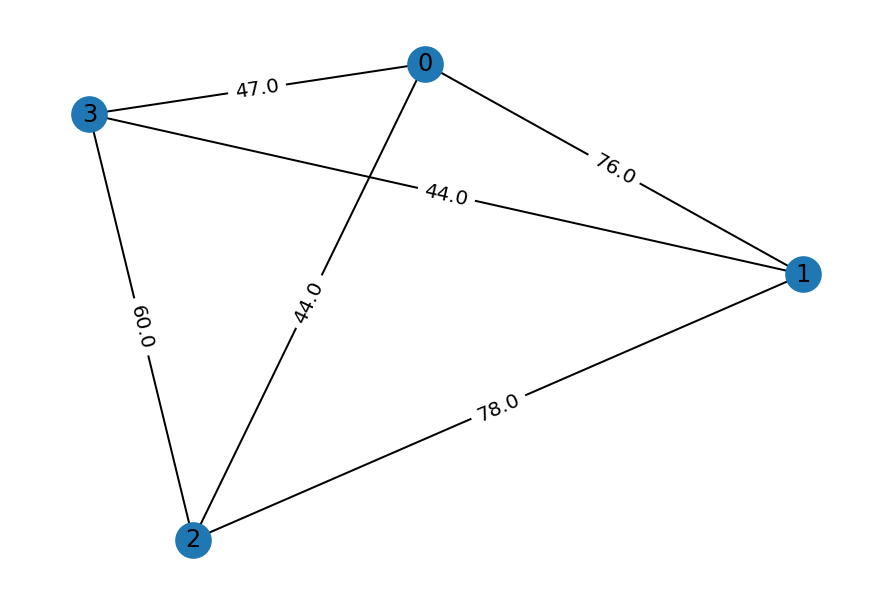

In [4]:
g = nx.Graph(rand_adj)

pos = nx.drawing.layout.random_layout(g, seed=42)
nx.draw(g, pos=pos)
edge_weights = nx.get_edge_attributes(g, "weight")
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_weights)
nx.draw_networkx_labels(g, pos=pos)

plt.show()

## Решение задачи TSP в NetworkX

Для того, чтобы потом понять, что все правильно сделали, давайте найдем приближенное решение задачи средствами `NetworkX`.

In [5]:
nx_solution = nx.algorithms.approximation.traveling_salesman_problem(g)
print(f"NetworkX solution (nodes order): {nx_solution}")

nx_solution_cost = 0
for i in range(len(nx_solution) - 1):
    nx_solution_cost += g.get_edge_data(nx_solution[i], nx_solution[i + 1])["weight"]

print(f"NetworkX solution (total cost): {nx_solution_cost}")

NetworkX solution (nodes order): [0, 3, 1, 2, 0]
NetworkX solution (total cost): 213.0


## Матрица $\sigma^z_{mod}$

Это бинарный оператор, который [ранее вводили](../problems2qml/np2ising.html#id3) в лекции о представлении комбинаторных задач в виде моделей Изинга.

In [6]:
def sigma_z_mod(k: int, size: int) -> sparse.csr_matrix:
    sz_mod = sparse.coo_matrix(
        [
            [1, 0,],
            [0, 0,],
        ]
    )

    left_ith = sparse.eye(2 ** k, format="coo")
    right_ith = sparse.eye(2 ** (size - k - 1), format="coo")

    return sparse.kron(
        sparse.kron(left_ith, sz_mod),
        right_ith,
    )

Напомним, что эта матрица имеет собственные значения 0 и 1, в чем легко убедиться, создав оператор маленькой размерности и вычислив все его собственные значения:

In [7]:
eigs = np.linalg.eig(sigma_z_mod(1, 3).toarray())
print(np.unique(eigs[0]))

[0. 1.]


Легко убедиться, что собственные операторы $\sigma^{z_{mod}}$ совпадают с собственными операторами $\sigma^z$, причем они имеют значение 1, когда спин с номером 2 имеет в битовой строке значение 0 и 1 если он имеет значение 1. Напомню, что у нас 0-индексация, поэтому `sigma_z_mod(1, 3)` значит что-то типа "построй мне матрицу $\sigma^{z_{mod}}$, действующую на второй спин (ну или второй кубит)".

In [8]:
def sigmaz_k(k: int, n: int) -> sparse.csr_matrix:
    left_part = sparse.eye(2 ** k)
    right_part = sparse.eye(2 ** (n - 1 - k))

    return sparse.kron(
        sparse.kron(
            left_part,
            sparse.csr_matrix(np.array([[1, 0,], [0, -1,],]))
        ),
        right_part
    )

def probs2bit_str(probs: np.array) -> str:
    size = int(np.log2(probs.shape[0]))
    bit_s_num = np.where(probs == probs.max())[0][0]
    s = f"{bit_s_num:b}"
    s = "0" * (size - len(s)) + s

    return s

for i, psi in enumerate(eigs[1]):
    probs = psi * psi.conj()
    bit_s = probs2bit_str(probs)
    print(f"Eigenvalue: {eigs[0][i]}\tBit string: {bit_s}")

Eigenvalue: 1.0	Bit string: 000
Eigenvalue: 1.0	Bit string: 001
Eigenvalue: 0.0	Bit string: 010
Eigenvalue: 0.0	Bit string: 011
Eigenvalue: 1.0	Bit string: 100
Eigenvalue: 1.0	Bit string: 101
Eigenvalue: 0.0	Bit string: 110
Eigenvalue: 0.0	Bit string: 111


Убедимся также в совпадении собственных векторов с матрицей $\sigma^z$:

```{note}
Для чистых состояний без запутывания матрицы собственных векторов могут быть приведены к виду единичных матриц. И действительно, каждый собственный вектор отвечает строго одной конфигурации спинов, а значит его волновая функция имеет вид $\ket{\Psi} = \ket{0, 0, ..., 1, ..., 0, 0}$, где 1 соответствует как раз номеру той битовой строки, которая отвечает этой конфигурации.
```

In [9]:
print(f"Sigma z_mod:\n{eigs[1]}")
print(f"\nSigma z:\n{np.linalg.eig(sigmaz_k(1, 3).toarray())[1]}")

Sigma z_mod:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

Sigma z:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


```{note}
В общем случае, даже если у двух операторов совпадают собственные вектора, то их порядок (по возрастанию собственных значений) совпадать совсем не обязан. В этом легко убедиться, например, если поменять местами $\hat{1}$ и $\hat{\sigma^z}$ в $\sigma^{z_{mod}}$. Поэтому, чтобы избежать ошибок в будущем, лучше не привыкать сравнивать матрицы собственных векторов при помощи `np.allclose`, а сравнивать их глазами построчно.
```

## Гамильтониан задачи TSP

Давайте еще раз выпишем полный гамильтониан системы. Напомню, что задача будет параметризована при помощи $N^2$ кубит, которые для удобства выстроены в виде матрицы, где $i$-я строка соответствует $i$-му шагу в цикле по графу, а $j$-й элемент строки соответствует номеру вершины и является бинарным оператором:

$$
\hat{H} = a\sum_{i=1}^N (1 - \sum_{j=1}^N \sigma^{z_{mod}}_{i,j})^2 + a\sum_{j=1}^N (1 - \sum_{i=1}^N \sigma^{z_{mod}}_{i,j})^2 + a \sum_{u,v \not\in E}\sum_{j=1}^{N-1}\sigma^{z_{mod}}_{u,j}\sigma^{z_{mod}}_{v,j+1} + b \sum_{u,v \in E}\sum_{j=1}^{N-1}\sigma^{z_{mod}}_{u,j}\sigma^{z_{mod}}_{v,j+1}
$$

```{note}
Еще раз вспомним, что первые два слагаемых "говорят": каждая вершина должна входить только в один столбец, а каждая строка должна содержать только одну вершину. Третье слагаемое представляет собой штраф за соединение вершин, между которыми нет ребра, а четвертое дает стоимость всего пути. Первые три слагаемых идут с бОльшим коэффициентом, чем последнее, так как нам важно в первую очередь получить реальное решение, а не получить самое дешевое.
```

Сделаем финт ушами: будем всегда считать, что путь коммивояжера начинается в вершине с индексом 0. Так как путь коммивояжера это гамильтонов цикл, то делаем это упрощение без какой-либо потери общности, так как вершина с индексом 0 все равно должна будет войти в путь. При этом такой хитрый трюк позволит снизить число необходимых кубит с $N^2$ до $(N - 1)^2$, что довольно существенно (хотя асимптотическая сложность остается такой же). Работать с графом будем при помощи уже знакомой библиотеки `NetworkX`:

In [10]:
def convert_tsp_to_ising(g: nx.Graph) -> sparse.coo_matrix:
    # Имеется два элемента гамильтониана:
    #  - часть, дающая нам Гамилтонов цикл
    #  - часть, считающая стоимость пути
    # Для нас важно, чтобы вес первой части превалирвал.
    # Поэтому, в качестве коэффициента берем
    # пятикратное значение максимального веса ребер в графе.

    a = 5 * max([e[2]["weight"] for e in g.edges(data=True)])
    size = g.number_of_nodes() - 1

    H = sparse.coo_matrix((2 ** (size ** 2), 2 ** (size ** 2)), dtype=np.complex128)

    # Вычисляем сумму по колонкам:
    #   - каждая вершина должна быть в каждой колонке строго один раз
    for i in range(size):
        # Считаем выражение 1 - sum
        col_sum = sparse.eye(2 ** (size ** 2), format="coo")
        for j in range(size):
            col_sum -= sigma_z_mod(i + j * size, size ** 2)

        # Возводим в квадрат и добавляем к гамилтониану
        H += a * col_sum * col_sum

    # Вычисляем сумму по строкам:
    #   - каждая вершина должна быть в каждой строке строго один раз
    for j in range(size):
        row_sum = sparse.eye(2 ** (size ** 2), format="coo")
        for i in range(size):
            row_sum -= sigma_z_mod(i + j * size, size ** 2)

        # Аналогично, в квадрат и добавляем
        H += a * row_sum * row_sum

    # Считаем сумму по тем ребрам, которых в графе нет и тем, которые есть.
    for i in range(size):
        for j in range(size):
            if g.has_edge(i + 1, j + 1):
                # Сумма по всем ребрам графа
                coef = g.get_edge_data(i + 1, j + 1)["weight"]
            else:
                # Сумма по всем отсутствующим ребрам графа
                coef = a

            for k in range(size - 1):
                # Дальше просто используем полученный коэффициент и считаем сумму
                H += (
                    coef
                    * sigma_z_mod(i + k * size, size ** 2)
                    * sigma_z_mod(j + (k + 1) * size, size ** 2)
                )

            H += (
                coef
                * sigma_z_mod(i + (size - 1) * size, size ** 2)
                * sigma_z_mod(j, size ** 2)
            )

    # Начинаем всегда из нулевой вершины, это позволяет снизить число необходимых кубитов.
    # Теперь должны добавить в гамильтониан слагаемое, отвечающее за нулевую вершину в пути.
    for j in range(size):
        if g.has_edge(0, j + 1):
            coef = g.get_edge_data(0, j + 1)["weight"]
        else:
            coef = a

        H += coef * sigma_z_mod(j, size ** 2)
        H += coef * sigma_z_mod(j + (size - 1) * size, size ** 2)

    # PennyLane работает с матрицами только в координатном формате, поэтому сразу делаем приведение.
    return sparse.coo_matrix(H)

Убедимся, что точное решение даст тот же путь (с той же стоимостью), что и решение из `NetworkX`:

In [11]:
op = convert_tsp_to_ising(g)
scipy_solution = sl.eigs(op, k=1, which="SR", return_eigenvectors=True)
print(f"Ground state energy: {scipy_solution[0][0]:.4f}")

probs = scipy_solution[1] * scipy_solution[1].conj()
bit_s = probs2bit_str(probs)

# Нулевая вершина всегда первая
scipy_path = [0,]

for i in range(3):
    k = 0
    for j in range(3):
        if bit_s[j + i * 3] == "0":
            k = j + 1
    scipy_path.append(k)
scipy_path.append(0)

scipy_solution_cost = 0
for i in range(len(scipy_path) - 1):
    scipy_solution_cost += g.get_edge_data(scipy_path[i], scipy_path[i + 1])["weight"]

print(f"SciPy solution (nodes order): {scipy_path}")
print(f"SciPy solution (total cost): {scipy_solution_cost}")

Ground state energy: 273.0000-0.0000j
SciPy solution (nodes order): [0, 2, 1, 3, 0]
SciPy solution (total cost): 213.0


Видим, что решение через матрицу совпадает с тем, что выдал `NetworkX` (с точностью до инверсии: `[0, 2, 1, 3, 0]` и `[0, 3, 1, 2, 0]`), как и общая стоимость пути. Энергия основного состояния отличается по причине того, что использовали оптимизацию и магию с коэффициентами. Но это не так важно: по энергиям важно лишь отношение порядка, потому что зная битовую строку всегда можем проверить стоимость пути за линейное время!

Теперь можно наконец-то, приступать к симуляции квантовых вычислений!

## VQE на Pennylane

Для начала давайте преобразуем матрицу к тому объекту, с которым умеет работать квантовый фреймворк.

```{note}
`Pennylane` поддерживает также работу с представлением гамильтонианов в виде так называемых Паули-строк, но тут не будем еще раз определять весь гамильтониан, а просто перериспользуем разреженную матрицу.
```

Веса графа имеют разброс значений от 0 до 100. Из-за этого, при некоторых конфигурациях можем получать очень большое собственное значение гамильтониана, вплоть до нескольких тысяч. Это не очень хорошо для градиентного спуска методом `paramter-shift`, поэтому для численной устойчивости давайте умножим все значения весов на $0.1$. Это сделает градиенты не слишком большими и улучшит численную устойчивость. Делать это можно совершенно спокойно, так как не критична численная величина минимального собственного, а важно лишь отношение порядка собственных значений.

In [12]:
import pennylane as qml

numer_stability_const = 0.1
ham = qml.SparseHamiltonian(op * numer_stability_const, wires=list(range(9)))

Далее необходимо выбрать _ansatz_. Современные квантовые процессоры обычно имеют вид решетки, типа такого:

```{figure} /_static/progblock/tfq/sycamore.png
:width: 350px
:name: sycamore_lattice

Схематичное изображение квантового компьютера _Sycamore_ от компании _Google_ {cite}`sycamore`
```

Поэтому, в идеале, хотелось бы делать либо однокубитные операции, либо двухкубитные операции, но над "соседними" кубитами. Так появилась идея _hardware efficient ansatz_ {cite}`hardware_ansatz`. Он заключается в том, что формируется несколько "слоев" **VQC**, где каждый такой слой содержит несколько операций вращений, а также попарные "запутывающие" операции (например, [_CZ_](../qcblock/gates.html#cy-cz), или гейт [_CNOT_](../qcblock/gates.html#cnot-cx)). Выглядит это примерно так:

```{figure} /_static/vqeblock/vqe/HWA.png
:width: 400px

Иллюстрация _hardware efficient ansatz_ (_HWEA_) из {cite}`hardware_ansatz`
```

Давайте реализуем такой слой:

In [13]:
size = len(ham.wires)

def layer(params):
    for i in range(size):
        qml.RY(params[i][0], wires=i)
        qml.RZ(params[i][1], wires=i)

    for i in range(size - 1):
        qml.CZ(wires=[i, i + 1])

Здесь специально не повторяем основ параметризированных квантовых схем. Для тех, кто забыл, что это такое, рекомендуем вернуться к [отдельной лекции](vqc) по этой теме.

Теперь создадим устройство, которое будет квантовым симулятором, а также напишем код, который будет на этом устройстве запускаться. Такой код должен последовательно применить несколько _HWEA_ слоев, после чего измерить ожидаемое значение гамильтониана в полученном состоянии.

In [14]:
device = qml.device("default.qubit", wires=size)
num_layers = 3

@qml.qnode(device, diff_method="parameter-shift")
def feed_forward(params, wires=size):
    for k in range(3):
        layer(params[k])

    for i in range(size):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.expval(ham)

Теперь надо сгенерировать параметры и выбрать метод их оптимизации. В этот раз давайте воспользуемся алгоритмом `Momentum`, так называемым "ускоренным" градиентным спуском:

In [15]:
opt = qml.MomentumOptimizer()
params = tuple(
    tuple(
        (
            np.random.rand() * 2 * np.pi,
            np.random.rand() * 2 * np.pi,
        )
        for _ in range(size)
    )
    for _ in range(num_layers + 1)
)

Ну и наконец можно приступать к оптимизации параметров. Все примерно также, как в [базовой лекции про градиенты](gradients). То есть ничего нового тут по сути не делается.

## Симуляция

```{warning}
Осторожно, следующий код работает несколько минут, так как обучаем довольно тяжелую схему на 9-и кубитах! Кстати, при желании можно добиться гораздо больше точности по энергии относительно точного решения. Для этого достаточно установить число эпох $\sim 150$. Но поскольку этот код исполняется при сборке данных лекций, то мы не можем себе позволить считать отдельные страницы по 7-10 минут. Читателю рекомендуется самостоятельно определить то число эпох, которого достаточно, чтобы получить точность в 3-м знаке после запятой.
```

In [16]:
energy = [
    feed_forward(params),
]

for epoch in range(85):
    params, e = opt.step_and_cost(feed_forward, params)
    energy.append(e)

    if epoch % 5 == 0:
        print(f"epoch: {epoch}\tenergy: {e:.6f}")

epoch: 0	energy: 360.638506


epoch: 5	energy: 163.172963


epoch: 10	energy: 96.375950


epoch: 15	energy: 56.524352


epoch: 20	energy: 43.497589


epoch: 25	energy: 35.938162


epoch: 30	energy: 31.882151


epoch: 35	energy: 29.457526


epoch: 40	energy: 29.232270


epoch: 45	energy: 28.058306


epoch: 50	energy: 27.814023


epoch: 55	energy: 27.495886


epoch: 60	energy: 27.479515


epoch: 65	energy: 27.411348


epoch: 70	energy: 27.348231


epoch: 75	energy: 27.329692


epoch: 80	energy: 27.324815


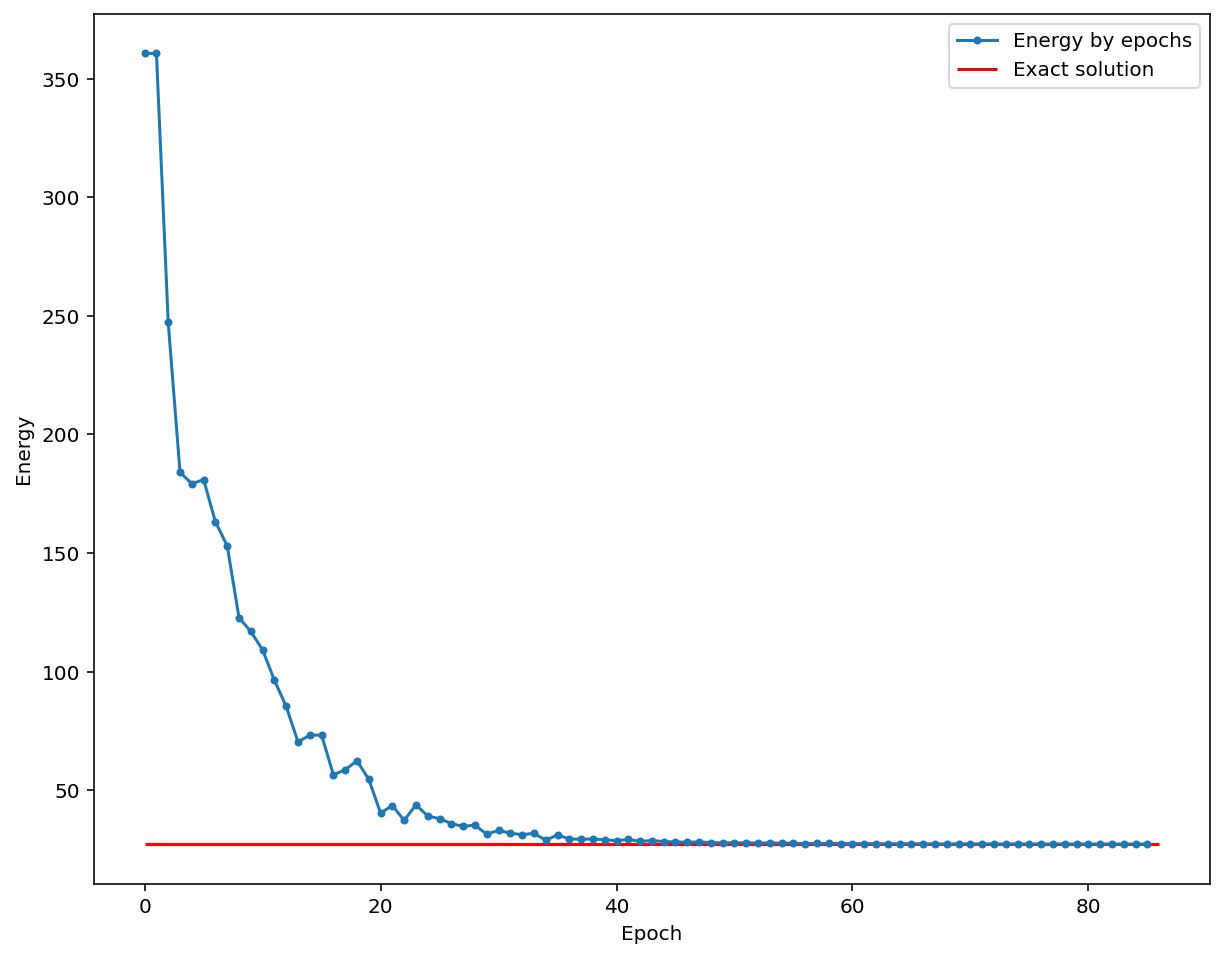

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(energy)), energy, ".-", label="Energy by epochs")
plt.hlines(
    np.real(scipy_solution[0][0]) * numer_stability_const,
    0,
    len(energy),
    color="red",
    label="Exact solution",
)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.legend()
plt.show()

Видим, что **VQE** отлично сходится к основному состоянию, которое знаем из `SciPy` и `ARPACK`. Теперь давайте убедимся, что квантовый путь совпадет с тем, что получили из `NetworkX`. Для этого нужно получить распределение вероятностей битовых строк. На реальном компьютере это можно сделать просто измеряя много раз, но на симуляторе есть возможность получить его сразу одной командой.

In [18]:
@qml.qnode(device, diff_method="parameter-shift")
def answer(params, wires=size):
    for k in range(num_layers):
        layer(params[k])

    for i in range(size):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.probs(wires=list(range(size)))

probs = answer(params)
bit_s = probs2bit_str(probs)

# Нулевая вершина всегда первая
q_path = [0,]

for i in range(3):
    k = 0
    for j in range(3):
        if bit_s[j + i * 3] == "0":
            k = j + 1
    q_path.append(k)
q_path.append(0)

q_solution_cost = 0
for i in range(len(q_path) - 1):
    q_solution_cost += g.get_edge_data(q_path[i], q_path[i + 1])["weight"]

print(f"Quantum solution (nodes order): {q_path}")
print(f"Quantum solution (total cost): {q_solution_cost}")

Quantum solution (nodes order): [0, 2, 1, 3, 0]
Quantum solution (total cost): 213.0


Ура, получился тот же ответ, что и в `SciPy`/`NetworkX`. Значит самописный **VQE** работает правильно.

## Заключение

В этой лекции попрактиковались в решение реальных задач при помощи алгоритма **VQE**.